## Description
This notebook provides two plotting functions that visualize the quality of clustering results from DBSCAN and LDA. The output of the search engine has been manually validated and saved in CSV format.

The code was developed with support from ChatGPT-4.

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def plot_search_validation(csv_path_dbscan, csv_path_lda, searchtitle):
    # Load CSV files
    df_lda = pd.read_csv(csv_path_lda, sep=";", encoding="utf-8")
    df_dbscan = pd.read_csv(csv_path_dbscan, sep=";", encoding="utf-8")

    # Map label values to colors
    label_colors = {'T': 'green', 'F': 'red', 'P': 'grey'}

    # Determine the maximum bar length for shared x-axis
    max_len = max(len(df_lda), len(df_dbscan))

    # Function to plot a single row of color blocks
    def plot_label_sequence(ax, labels, title):
        for idx, label in enumerate(labels):
            color = label_colors.get(label, 'white')
            # Farbiges Rechteck
            ax.add_patch(plt.Rectangle((idx, 0), 0.9, 1, color=color))
            # Schwarze Trennlinie rechts
            ax.add_patch(plt.Rectangle((idx + 0.9, 0), 0.1, 1, color='black'))
        ax.set_xlim(0, max_len)
        ax.set_ylim(0, 1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"{title} ({len(labels)} Treffer)", fontsize=16)

    # Create the subplot figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(max_len * 0.2, 2.5), sharex=True)

    plot_label_sequence(ax1, df_dbscan['validation'], "DBSCAN")
    plot_label_sequence(ax2, df_lda['validation'], "LDA")

    ax2.text(0, 1.2, "Suchergebnisse absteigend (links nach rechts -->)", ha='left', fontsize=16)

    # Title for the entire figure
    fig.suptitle(f"Vergleich der Clusterverfahren mit Suchanfrage \"{searchtitle}\"", fontsize=22)

    # Legend placed bottom right beneath the plot
    legend_patches = [
        mpatches.Patch(color='green', label='Relevanter Treffer (T)'),
        mpatches.Patch(color='red', label='Nicht passend (F)'),
        mpatches.Patch(color='grey', label='Teilweise passend (P)')
    ]
    fig.legend(handles=legend_patches, loc='upper right', bbox_to_anchor=(1, 1.1), ncol=1, fontsize=16)

    # Adjust layout to make space for the title
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def plot_shared_entries(csv_path_dbscan, csv_path_lda, searchtitle):
    # Load CSV files
    df_lda = pd.read_csv(csv_path_lda, sep=";", encoding="utf-8")
    df_dbscan = pd.read_csv(csv_path_dbscan, sep=";", encoding="utf-8")

    # Columns to identify shared records
    compare_cols = ['dataset_title_DE', 'dataset_description_DE', 'dataset_keyword_DE']

    # Identify shared entries based on matching columns
    merged = pd.merge(df_dbscan, df_lda, on=compare_cols, how='inner')
    shared_keys = set(merged.apply(lambda row: tuple(row[col] for col in compare_cols), axis=1))

    # Color assignment: orange = shared, blue = unique
    def get_color_sequence(df, key_columns):
        colors = []
        for _, row in df.iterrows():
            key = tuple(row[col] for col in key_columns)
            colors.append('orange' if key in shared_keys else 'blue')
        return colors

    colors_dbscan = get_color_sequence(df_dbscan, compare_cols)
    colors_lda = get_color_sequence(df_lda, compare_cols)

    # Maximum length for common axis scale
    max_len = max(len(df_dbscan), len(df_lda))

    # Plotting function
    def plot_custom_color_sequence(ax, colors, title):
        for idx, color in enumerate(colors):
            # Farbiges Rechteck (0.9 breit)
            ax.add_patch(plt.Rectangle((idx, 0), 0.9, 1, color=color))
            # Schwarze Trennlinie (0.1 breit)
            ax.add_patch(plt.Rectangle((idx + 0.9, 0), 0.1, 1, color='black'))
        ax.set_xlim(0, max_len)
        ax.set_ylim(0, 1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"{title} ({len(colors)} Treffer)", fontsize=16)

    # Create plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(max_len * 0.2, 2.5), sharex=True)

    plot_custom_color_sequence(ax1, colors_dbscan, "DBSCAN")
    plot_custom_color_sequence(ax2, colors_lda, "LDA")

    # Add note below second bar
    ax2.text(0, 1.2, "Suchergebnisse absteigend (links nach rechts -->)", ha='left', fontsize=16)

    # Overall title
    fig.suptitle(f"Übersicht gemeinsamer und nur in DBSCAN oder LDA vorkommende Suchergebnisse", fontsize=22)

    # Legend
    legend_patches = [
        mpatches.Patch(color='orange', label='gemeinsame Treffer'),
        mpatches.Patch(color='blue', label='nur in DBSCAN/LDA')
    ]
    fig.legend(handles=legend_patches, loc='upper right', bbox_to_anchor=(1, 1.1), ncol=1, fontsize=16)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [46]:
import pandas as pd
from tabulate import tabulate

def evaluate_search_results(csv_path_dbscan, csv_path_lda):
    # Columns used to match shared entries
    compare_cols = ['dataset_title_DE', 'dataset_description_DE', 'dataset_keyword_DE']

    # Load CSV files
    df_dbscan = pd.read_csv(csv_path_dbscan, sep=";", encoding="utf-8")
    df_lda = pd.read_csv(csv_path_lda, sep=";", encoding="utf-8")

    # Count T, P, F labels
    def count_labels(df):
        return {
            'T': (df['validation'] == 'T').sum(),
            'P': (df['validation'] == 'P').sum(),
            'F': (df['validation'] == 'F').sum()
        }

    # Count shared entries between both result sets
    shared_keys = set(
        pd.merge(df_dbscan, df_lda, on=compare_cols, how='inner')
        .apply(lambda row: tuple(row[col] for col in compare_cols), axis=1)
    )

    def count_unique(df, shared):
        return sum(
            tuple(row[col] for col in compare_cols) not in shared
            for _, row in df.iterrows()
        )

    # Calculate basic metrics
    labels_dbscan = count_labels(df_dbscan)
    labels_lda = count_labels(df_lda)
    unique_dbscan = count_unique(df_dbscan, shared_keys)
    unique_lda = count_unique(df_lda, shared_keys)

    # Prepare result table
    table = [
        ['DBSCAN', len(df_dbscan), labels_dbscan['T'], labels_dbscan['P'], labels_dbscan['F'], unique_dbscan],
        ['LDA', len(df_lda), labels_lda['T'], labels_lda['P'], labels_lda['F'], unique_lda]
    ]

    headers = ['Method', 'Total Results', 'T (Relevant)', 'P (Partially)', 'F (Irrelevant)', 'Unique Results']

    print("\nAuswertung der Suchergebnisse:")
    print(tabulate(table, headers=headers, tablefmt="fancy_grid"))

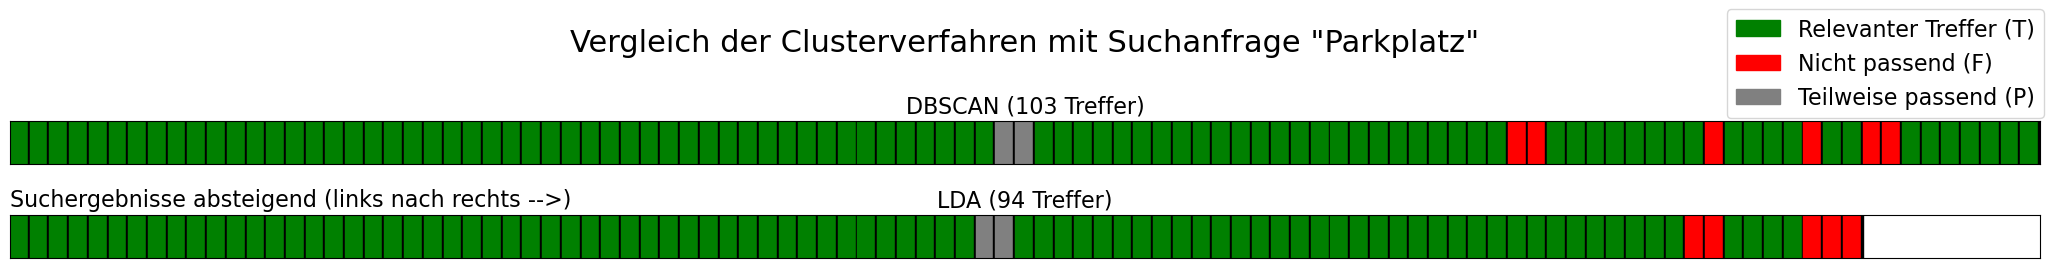

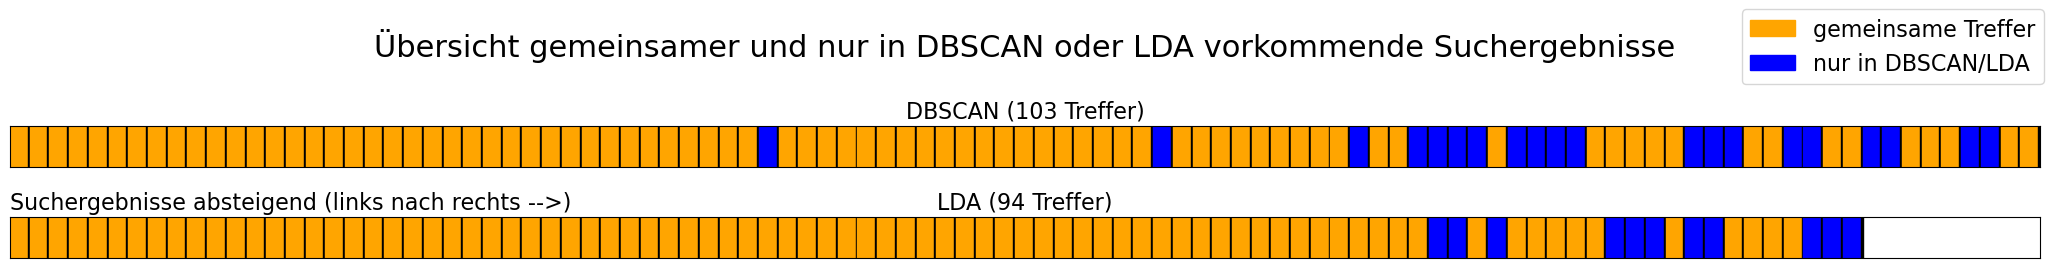


Auswertung der Suchergebnisse:
╒══════════╤═════════════════╤════════════════╤═════════════════╤══════════════════╤══════════════════╕
│ Method   │   Total Results │   T (Relevant) │   P (Partially) │   F (Irrelevant) │   Unique Results │
╞══════════╪═════════════════╪════════════════╪═════════════════╪══════════════════╪══════════════════╡
│ DBSCAN   │             103 │             95 │               2 │                6 │               20 │
├──────────┼─────────────────┼────────────────┼─────────────────┼──────────────────┼──────────────────┤
│ LDA      │              94 │             87 │               2 │                5 │               11 │
╘══════════╧═════════════════╧════════════════╧═════════════════╧══════════════════╧══════════════════╛


In [47]:
plot_search_validation(
    "data/search_results/validation_dbscan_search_result_Parkplatz.csv",
    "data/search_results/validation_lda_search_result_Parkplatz.csv",
    "Parkplatz"
)

plot_shared_entries(
    "data/search_results/validation_dbscan_search_result_Parkplatz.csv",
    "data/search_results/validation_lda_search_result_Parkplatz.csv",
    "Parkplatz"
)

evaluate_search_results(
    "data/search_results/validation_dbscan_search_result_Parkplatz.csv",
    "data/search_results/validation_lda_search_result_Parkplatz.csv"
)

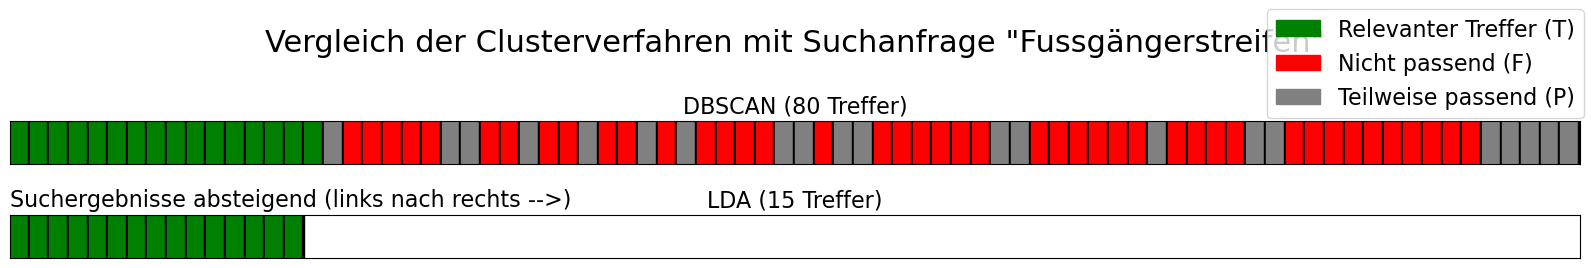

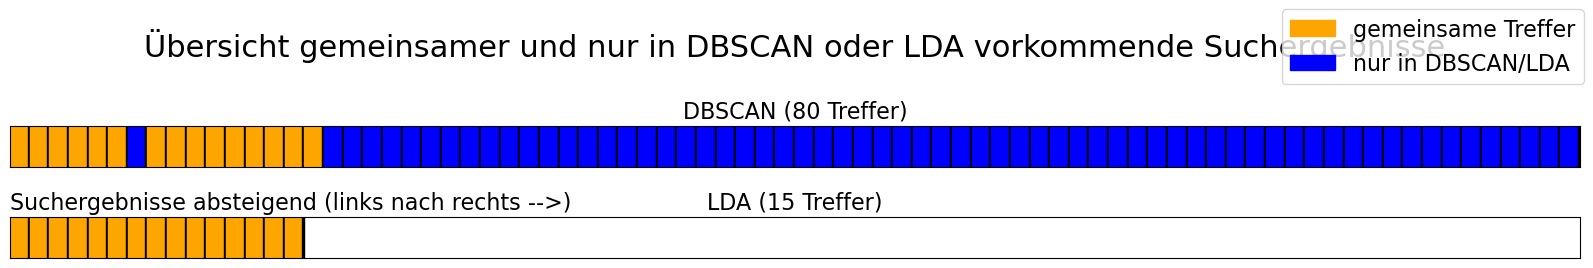


Auswertung der Suchergebnisse:
╒══════════╤═════════════════╤════════════════╤═════════════════╤══════════════════╤══════════════════╕
│ Method   │   Total Results │   T (Relevant) │   P (Partially) │   F (Irrelevant) │   Unique Results │
╞══════════╪═════════════════╪════════════════╪═════════════════╪══════════════════╪══════════════════╡
│ DBSCAN   │              80 │             16 │              21 │               43 │               65 │
├──────────┼─────────────────┼────────────────┼─────────────────┼──────────────────┼──────────────────┤
│ LDA      │              15 │             15 │               0 │                0 │                0 │
╘══════════╧═════════════════╧════════════════╧═════════════════╧══════════════════╧══════════════════╛


In [48]:
plot_search_validation(
    "data/search_results/validation_dbscan_search_result_Fussgängerstreifen.csv",
    "data/search_results/validation_lda_search_result_Fussgängerstreifen.csv",
    "Fussgängerstreifen"
)

plot_shared_entries(
    "data/search_results/validation_dbscan_search_result_Fussgängerstreifen.csv",
    "data/search_results/validation_lda_search_result_Fussgängerstreifen.csv",
    "Fussgängerstreifen"
)

evaluate_search_results(
    "data/search_results/validation_dbscan_search_result_Fussgängerstreifen.csv",
    "data/search_results/validation_lda_search_result_Fussgängerstreifen.csv"
)

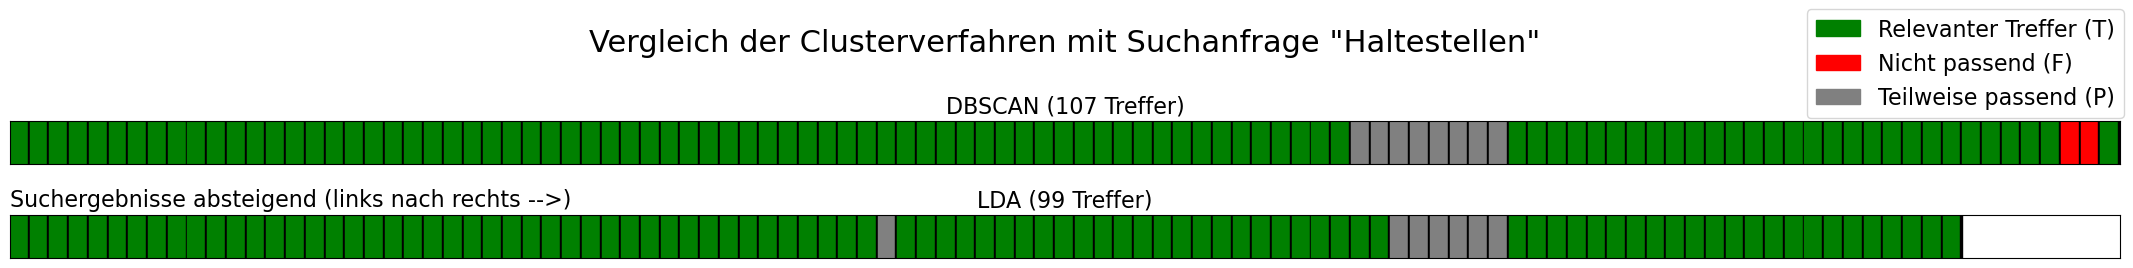

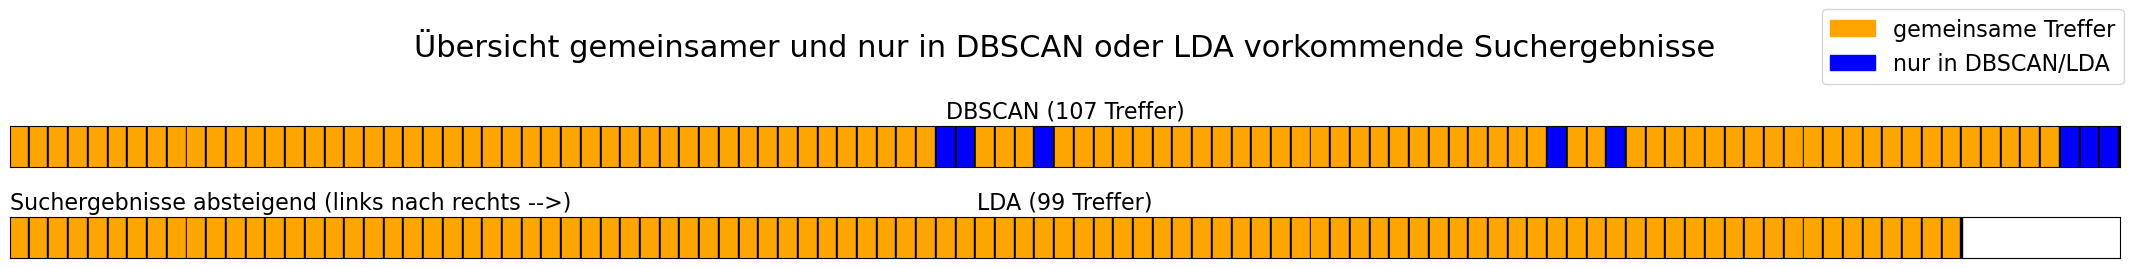


Auswertung der Suchergebnisse:
╒══════════╤═════════════════╤════════════════╤═════════════════╤══════════════════╤══════════════════╕
│ Method   │   Total Results │   T (Relevant) │   P (Partially) │   F (Irrelevant) │   Unique Results │
╞══════════╪═════════════════╪════════════════╪═════════════════╪══════════════════╪══════════════════╡
│ DBSCAN   │             107 │             97 │               8 │                2 │                8 │
├──────────┼─────────────────┼────────────────┼─────────────────┼──────────────────┼──────────────────┤
│ LDA      │              99 │             92 │               7 │                0 │                0 │
╘══════════╧═════════════════╧════════════════╧═════════════════╧══════════════════╧══════════════════╛


In [49]:
plot_search_validation(
    "data/search_results/validation_dbscan_search_result_Haltestellen.csv",
    "data/search_results/validation_lda_search_result_Haltestellen.csv",
    "Haltestellen"
)

plot_shared_entries(
    "data/search_results/validation_dbscan_search_result_Haltestellen.csv",
    "data/search_results/validation_lda_search_result_Haltestellen.csv",
    "Haltestellen"
)

evaluate_search_results(
    "data/search_results/validation_dbscan_search_result_Haltestellen.csv",
    "data/search_results/validation_lda_search_result_Haltestellen.csv"
)

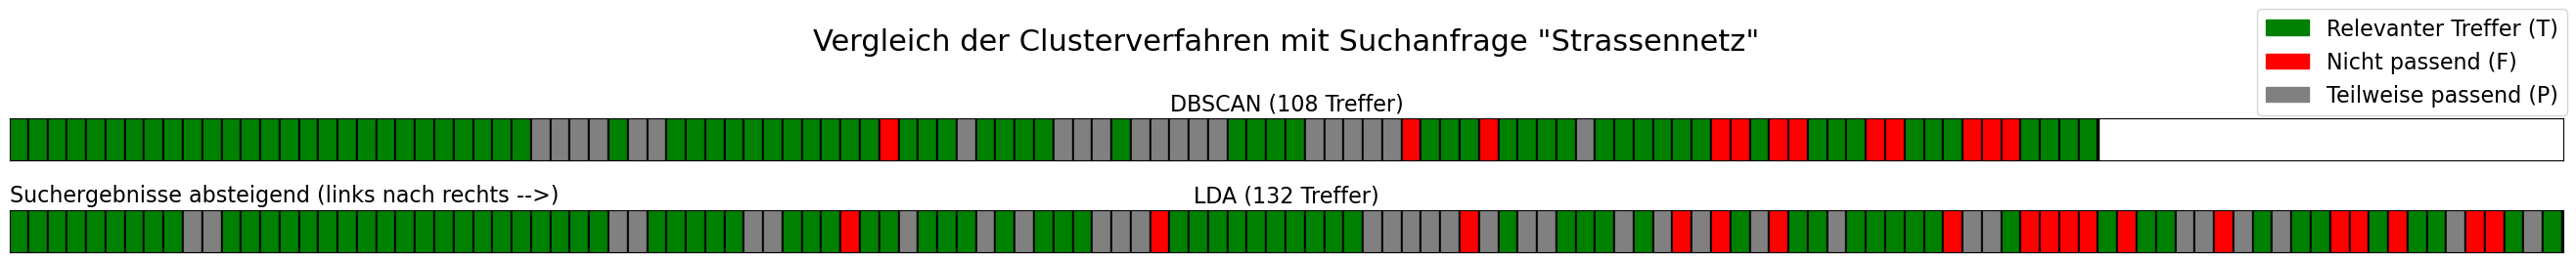

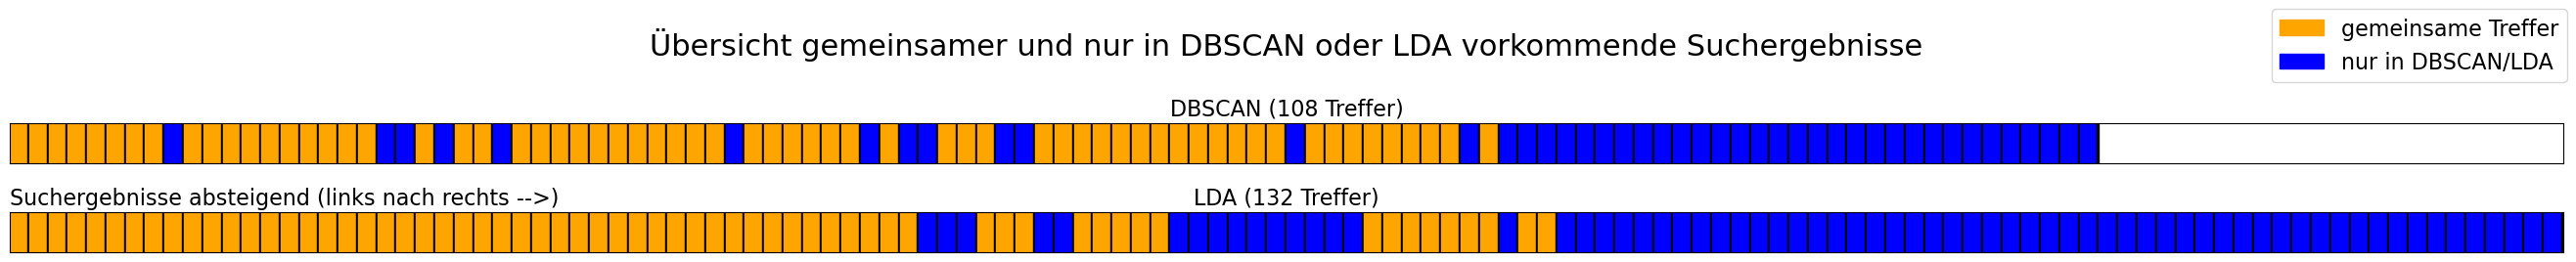


Auswertung der Suchergebnisse:
╒══════════╤═════════════════╤════════════════╤═════════════════╤══════════════════╤══════════════════╕
│ Method   │   Total Results │   T (Relevant) │   P (Partially) │   F (Irrelevant) │   Unique Results │
╞══════════╪═════════════════╪════════════════╪═════════════════╪══════════════════╪══════════════════╡
│ DBSCAN   │             108 │             75 │              21 │               12 │               44 │
├──────────┼─────────────────┼────────────────┼─────────────────┼──────────────────┼──────────────────┤
│ LDA      │             132 │             81 │              33 │               18 │               68 │
╘══════════╧═════════════════╧════════════════╧═════════════════╧══════════════════╧══════════════════╛


In [50]:
plot_search_validation(
    "data/search_results/validation_dbscan_search_result_Strassennetz.csv",
    "data/search_results/validation_lda_search_result_Strassennetz.csv",
    "Strassennetz"
)

plot_shared_entries(
    "data/search_results/validation_dbscan_search_result_Strassennetz.csv",
    "data/search_results/validation_lda_search_result_Strassennetz.csv",
    "Strassennetz"
)

evaluate_search_results(
    "data/search_results/validation_dbscan_search_result_Strassennetz.csv",
    "data/search_results/validation_lda_search_result_Strassennetz.csv"
)

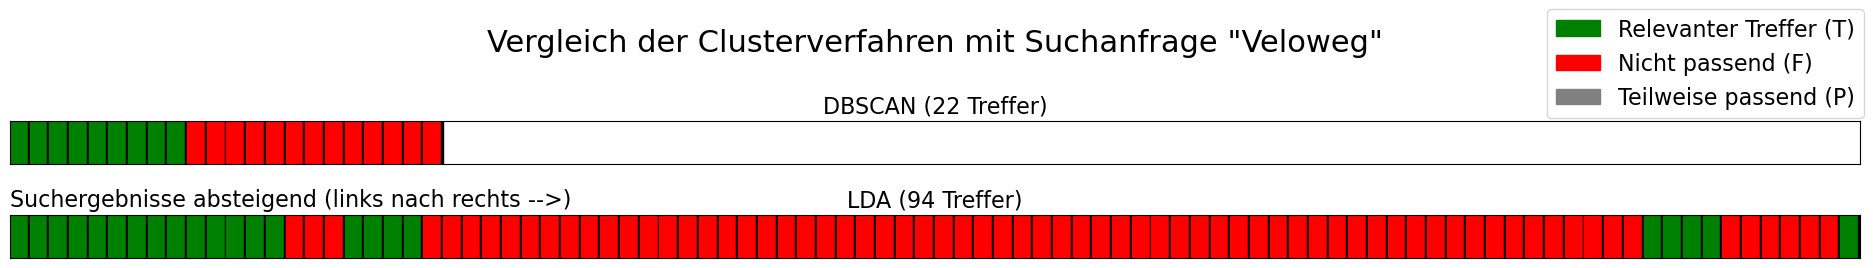

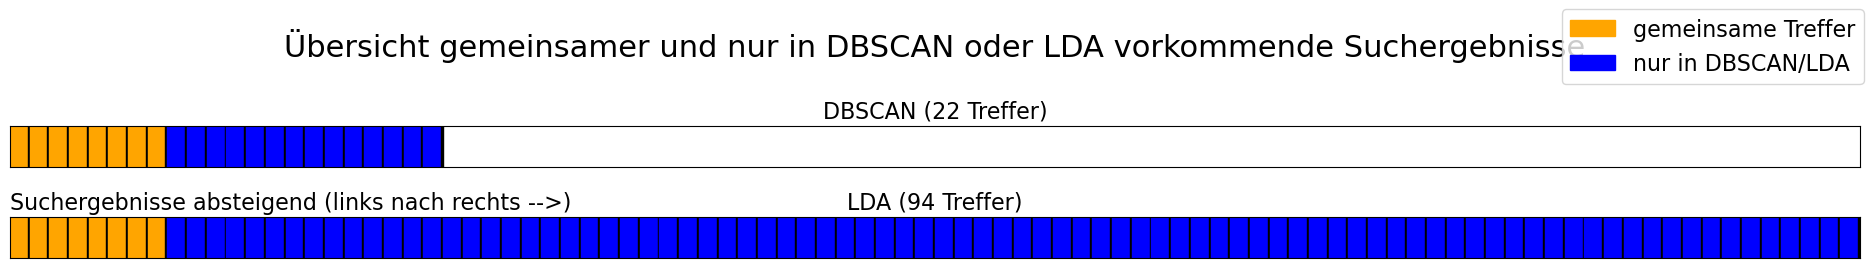


Auswertung der Suchergebnisse:
╒══════════╤═════════════════╤════════════════╤═════════════════╤══════════════════╤══════════════════╕
│ Method   │   Total Results │   T (Relevant) │   P (Partially) │   F (Irrelevant) │   Unique Results │
╞══════════╪═════════════════╪════════════════╪═════════════════╪══════════════════╪══════════════════╡
│ DBSCAN   │              22 │              9 │               0 │               13 │               14 │
├──────────┼─────────────────┼────────────────┼─────────────────┼──────────────────┼──────────────────┤
│ LDA      │              94 │             23 │               0 │               71 │               86 │
╘══════════╧═════════════════╧════════════════╧═════════════════╧══════════════════╧══════════════════╛


In [51]:
plot_search_validation(
    "data/search_results/validation_dbscan_search_result_Veloweg.csv",
    "data/search_results/validation_lda_search_result_Veloweg.csv",
    "Veloweg"
)

plot_shared_entries(
    "data/search_results/validation_dbscan_search_result_Veloweg.csv",
    "data/search_results/validation_lda_search_result_Veloweg.csv",
    "Veloweg"
)

evaluate_search_results(
    "data/search_results/validation_dbscan_search_result_Veloweg.csv",
    "data/search_results/validation_lda_search_result_Veloweg.csv"
)